# Lightgbm incremental training

# Functions 

We spent quite a bit of time developing two functions in the previous notebook:

* `agg_numeric`: calculate aggregation statistics (`mean`, `count`, `max`, `min`) for numeric variables.
* `agg_categorical`: compute counts and normalized counts of each category in a categorical variable.

Together, these two functions can extract information about both the numeric and categorical data in a dataframe. Our general approach will be to apply both of these functions to the dataframes, grouping by the client id, `SK_ID_CURR`. For the `POS_CASH_balance`, `credit_card_balance`, and `installment_payments`, we can first group by the `SK_ID_PREV`, the unique id for the previous loan. Then we will group the resulting dataframe by the `SK_ID_CURR` to calculate the aggregation statistics for each client across all of their previous loans. If that's a little confusing, I'd suggest heading back to the [first feature engineering notebook](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output).**

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
def preprocess(train,test = None):
    
    train_labels = train['TARGET']
    train = train.drop(columns=['TARGET','SK_ID_CURR'])
    test = test.drop(columns = ['SK_ID_CURR'])
    
    train = pd.get_dummies(train)
    test = pd.get_dummies(test)
    print('Dummy Variables Done')
        
    fill_median = train.dropna(axis = 0).median()
    train = train.fillna(fill_median, axis = 0)
    test = test.fillna(fill_median, axis = 0)
    print('Fillna Done')
    
    train,test = train.align(test, join = 'inner', axis = 1)
    train_features = list(train.columns)

    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    print('Scaling Done')
    
    print('Training data shape: ',train.shape)
    print('Testing data shape: ',test.shape)
    
    from sklearn.model_selection import train_test_split
    X_train,X_val,y_train,y_val = train_test_split(train, train_labels, test_size = 0.2)
    
    X_train = pd.DataFrame(X_train)
    X_train.columns = train_features
    X_train['TARGET'] = y_train.reset_index(drop = True)
    
    X_val = pd.DataFrame(X_val)
    X_val.columns = train_features
    X_val['TARGET'] = y_val.reset_index(drop = True)
    print('Train Test Split Done')
    
    print('X_train shape:', X_train.shape)
    print('X_val shape: ',X_val.shape)
    
    X_test = pd.DataFrame(test,columns = train_features)
    
    X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]
    X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]
    
    X_train.to_csv('D:/home-credit-default-risk/train.csv', index = False, chunksize = 5000)
#     X_val.to_csv('D:/home-credit-default-risk/val.csv', index = False, chunksize = 5000)
    print('X_train Saved')
    
    return X_val, X_test

## Modeling

In [3]:
train = pd.read_csv('D:/home-credit-default-risk/train_previous_raw.csv')
test = pd.read_csv('D:/home-credit-default-risk/test_previous_raw.csv')

In [4]:
X_val, X_test = preprocess(train,test)

Dummy Variables Done
Fillna Done
Scaling Done
Training data shape:  (307511, 1252)
Testing data shape:  (48744, 1252)
Train Test Split Done
X_train shape: (246008, 1253)
X_val shape:  (61503, 1253)
X_train Saved


## Incremental Training

In [5]:
import lightgbm as lgb
# The first step is to initialize the model as None and set the model parameters.
gbm=None
params = {
        'task': 'train',
        'application': 'binary',
        'metric':'auc',
        'is_unbalance': 'True', 
        'learning_rate': '0.05', 
        'reg_alpha': '0.1',
        'reg_lambda': '0.1', 
        'subsample': '0.8',
        'n_jobs': '4',
        'device_type': 'cpu'
    }

# The second step is streaming data (100,000 at a time)

i=1
size = 60000
for sub_data in pd.read_csv('D:/home-credit-default-risk/train.csv', chunksize=size):
    
    print('\nCum Training Data: {} records\n'.format(i*size))
    
    x_cols = list(sub_data.columns)[:-1]
    y_cols = 'TARGET'
    
    x_data = sub_data[x_cols]
    y_data = sub_data[y_cols]

    lgb_train = lgb.Dataset(x_data, y_data.values)
    lgb_eval = lgb.Dataset(X_val[x_cols], X_val[y_cols].values, reference=lgb_train)

    # Step 3: Incremental Training Model
    # Emphasis is laid on incremental training through init_model and keep_training_booster parameters.
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    init_model=gbm,             # If gbm is not None, then it is on the basis of the last training.
                    feature_name=x_cols,
                    early_stopping_rounds=10,
                    verbose_eval=False,
                    keep_training_booster=True) # Incremental training

    # Output Model Assessment Score
    print(gbm)
    print('Training set score：auc = %.4f'%(gbm.eval_train()[0][2]))
    print('Val set score：auc = %.4f'%(gbm.eval_valid()[0][2]))
    i += 1


Cum Training Data: 60000 records

Training set score：auc = 0.8779
Val set score：auc = 0.7637

Cum Training Data: 120000 records

Training set score：auc = 0.8166
Val set score：auc = 0.7665

Cum Training Data: 180000 records

Training set score：auc = 0.7891
Val set score：auc = 0.7665

Cum Training Data: 240000 records

Training set score：auc = 0.7913
Val set score：auc = 0.7666

Cum Training Data: 300000 records

Training set score：auc = 0.8451
Val set score：auc = 0.7629


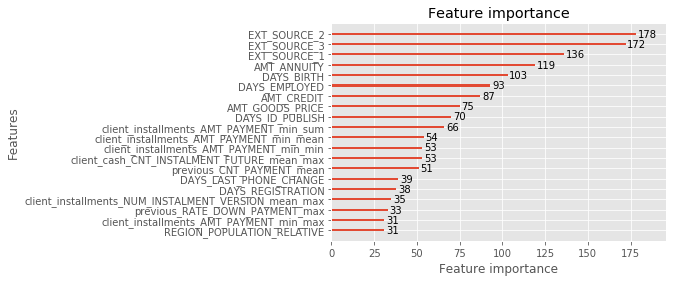

In [6]:
lgb.plot_importance(gbm, max_num_features = 20)

In [13]:
gbm.predict(X_test)

array([0.1974377 , 0.57386603, 0.27367214, ..., 0.14695008, 0.26673747,
       0.71246017])